# Env

In [2]:
import os
import numpy as np
from tqdm import tqdm
import random
import pickle
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from models.model import *
from utils.metrics import *

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

c:\Users\kimhy\anaconda3\envs\ts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [3]:
def seed_everything(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
def generate_data(flag, size, phi, theta=None):
        
    ''' 
    flag = ar1, ar2, arma11
    '''

    if flag == 'ar1':
        e = np.random.normal(0, 1, size)
        x = np.array(np.repeat(0, size), dtype=np.float64)
        x[0] = e[0]
        for i in range(1, size):
            x[i] = x[i-1]*phi + e[i]
    elif flag == 'ar2':
        e = np.random.normal(0, 1, size)
        x = np.array(np.repeat(0, size), dtype=np.float64)
        x[0] = e[0]
        x[1] = x[0]*phi + e[1]
        for i in range(2, size):
            x[i] = (x[i-1]*phi) + (x[i-2]*0.2) + e[i]
    elif flag == 'arma11':
        e = np.random.normal(0, 1, size)
        x = np.array(np.repeat(0, size), dtype=np.float64)
        x[0] = e[0]
        for i in range(1, size):
            x[i] = x[i-1]*phi + e[i-1]*theta + e[i]

    return x

[AR(2)] 

$ \rho = \frac{\phi_1}{1-\phi_2} $

[ARMA(1,1)]

$ \rho = \frac{(\phi - \theta)(1 - \phi\theta)}{1 - 2\phi\theta + \theta^2} $

In [4]:
def corr(a, b):
    '''
    ARMA(1,1) autocorrelation
    a = theta
    b = phi
    '''
    res = (a-b)*(1-a*b)/(1-2*a*b+b**2)
    return res

In [6]:
print(f'phi=0.7, theta=0.5: {corr(0.7,0.5)}')
print(f'phi=0.8, theta=0.4: {corr(0.8,0.4)}')
print(f'phi=0.9, theta=0.4: {corr(0.9,0.4)}')
print(f'phi=0.9, theta=-0.4: {corr(0.9,-0.4)}')

phi=0.7, theta=0.5: 0.2363636363636363
phi=0.8, theta=0.4: 0.5230769230769231
phi=0.9, theta=0.4: 0.7272727272727273
phi=0.9, theta=-0.4: 0.9404255319148935


# Train

In [4]:
# Data Generation
train_data = []
vali_data = []

window_size = 24
batch_size = 32

# AR(1)
train_data.append(generate_data('ar1', 1200, 0))
vali_data.append(generate_data('ar1', 400, 0))
train_data.append(generate_data('ar1', 1200, 0.25))
vali_data.append(generate_data('ar1', 400, 0.25))
train_data.append(generate_data('ar1', 1200, 0.5))
vali_data.append(generate_data('ar1', 400, 0.5))
train_data.append(generate_data('ar1', 1200, 0.75))
vali_data.append(generate_data('ar1', 400, 0.75))
train_data.append(generate_data('ar1', 1200, 0.95))
vali_data.append(generate_data('ar1', 400, 0.95))

# AR(2)
train_data.append(generate_data('ar2', 1200, 0.2)) # r=0.25
vali_data.append(generate_data('ar2', 400, 0.2))
train_data.append(generate_data('ar2', 1200, 0.4)) # r=0.5
vali_data.append(generate_data('ar2', 400, 0.4))
train_data.append(generate_data('ar2', 1200, 0.6)) # r=0.75
vali_data.append(generate_data('ar2', 400, 0.6))
train_data.append(generate_data('ar2', 1200, 0.76)) # r=0.95
vali_data.append(generate_data('ar2', 400, 0.76))

# ARMA(1,1)
train_data.append(generate_data('arma11', 1200, 0.7, 0.5)) # r=0.236
vali_data.append(generate_data('arma11', 400, 0.7, 0.5))
train_data.append(generate_data('arma11', 1200, 0.8, 0.4)) # r=0.523
vali_data.append(generate_data('arma11', 400, 0.8, 0.4))
train_data.append(generate_data('arma11', 1200, 0.9, 0.4)) # r=0.73
vali_data.append(generate_data('arma11', 400, 0.9, 0.4))
train_data.append(generate_data('arma11', 1200, 0.9, -0.4)) # r=0.94
vali_data.append(generate_data('arma11', 400, 0.9, -0.4))


train_data = np.array(train_data).flatten()
vali_data = np.array(vali_data).flatten()

# Min-Max Scale
min_train, max_train = np.min(train_data), np.max(train_data)
train_scaled = list()
for x in train_data:
    train_scaled.append((x-min_train)/(max_train-min_train))

# Sliding Window
train_size = len(train_scaled)
train_x = list()
for i in range(train_size-window_size):
    train_x.append(train_scaled[i:i+window_size])
train_x = np.array(train_x).reshape(-1,window_size,1) # Train Input
train_y = np.array(train_scaled[window_size:]).reshape(-1,1,1)

# Make it as an input to the model
train_input = Variable(torch.Tensor(train_x)).to(device)
train_output = Variable(torch.Tensor(train_y)).to(device)
train = TensorDataset(train_input, train_output)
train_loader = DataLoader(train, batch_size, shuffle=True)

# Same process on validation dataset
vali_scaled = list()
for x in vali_data:
    vali_scaled.append((x-min_train)/(max_train-min_train))
vali_size = len(vali_scaled)
vali_x = list()
for i in range(vali_size-window_size):
    vali_x.append(vali_scaled[i:i+window_size])
vali_x = np.array(vali_x).reshape(-1,window_size,1) # vali Input
vali_y = np.array(vali_scaled[window_size:]).reshape(-1,1,1)
vali_input = Variable(torch.Tensor(vali_x)).to(device)
vali_output = Variable(torch.Tensor(vali_y)).to(device)
vali = TensorDataset(vali_input, vali_output)
vali_loader = DataLoader(vali, batch_size, shuffle=True)

In [8]:
min_max = [min_train, max_train]

with open(file='train_min_max.pkl', mode='wb') as f:
    pickle.dump(min_max, f)

print(f'Minimum: {min_train}')
print(f'Maximum: {max_train}')

Minimum: -10.02100740136445
Maximum: 12.51405089905591


In [5]:
# Train NLinear
args = dotdict()

args.seq_len = 24 # input length
args.pred_len = 1 # output length
args.enc_in = 1
args.individual = False

model = NLinear(args).to(device)
learning_rate = 1e-06
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
opt = Optimization(model, loss_fn, optimizer)

In [10]:
opt.train(train_loader, vali_loader, epochs=1000)

Validation loss decreased (inf --> 0.035025).  Saving model ...
[1/1000] Training loss: 0.0349/t Validation loss: 0.0350
Validation loss decreased (0.035025 --> 0.034816).  Saving model ...
[2/1000] Training loss: 0.0347/t Validation loss: 0.0348
Validation loss decreased (0.034816 --> 0.034630).  Saving model ...
[3/1000] Training loss: 0.0345/t Validation loss: 0.0346
Validation loss decreased (0.034630 --> 0.034447).  Saving model ...
[4/1000] Training loss: 0.0344/t Validation loss: 0.0344
Validation loss decreased (0.034447 --> 0.034256).  Saving model ...
[5/1000] Training loss: 0.0342/t Validation loss: 0.0343
Validation loss decreased (0.034256 --> 0.034068).  Saving model ...
[6/1000] Training loss: 0.0340/t Validation loss: 0.0341
Validation loss decreased (0.034068 --> 0.033892).  Saving model ...
[7/1000] Training loss: 0.0338/t Validation loss: 0.0339
Validation loss decreased (0.033892 --> 0.033693).  Saving model ...
[8/1000] Training loss: 0.0336/t Validation loss: 0.03

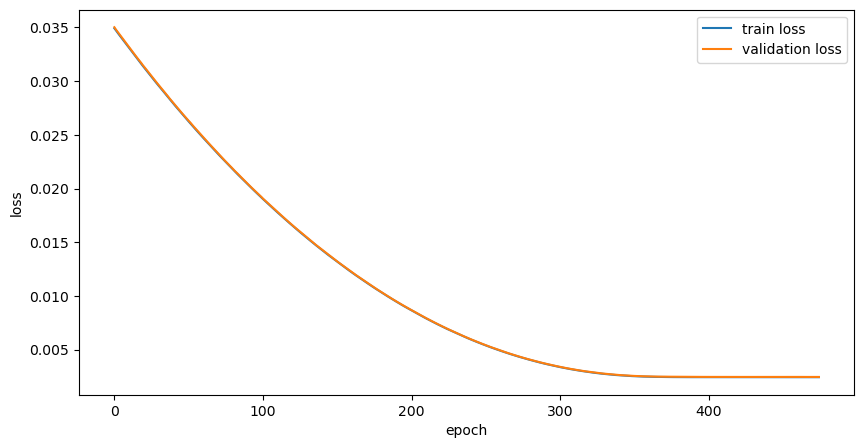

In [19]:
opt.plot_train_history()

In [6]:
seed_everything(302)
test_dataS = []
test_dataS.append(generate_data('ar1', 1000, 0.2))
test_dataS.append(generate_data('ar1', 1000, 0.8))
test_dataS.append(generate_data('ar2', 1000, 0.2))
test_dataS.append(generate_data('ar2', 1000, 0.76))
test_dataS.append(generate_data('arma11', 1000, 0.7, 0.5))
test_dataS.append(generate_data('arma11', 1000, 0.9, -0.4))

test_loaderS = []
for test_data in test_dataS:
    # Min-Max Scale
    test_data = test_data.flatten()
    test_scaled = list()
    for x in test_data:
        test_scaled.append((x-min_train)/(max_train-min_train))

    # Sliding Window
    test_size = len(test_scaled)
    test_x = list()
    for i in range(test_size-window_size):
        test_x.append(test_scaled[i:i+window_size])
    test_x = np.array(test_x).reshape(-1,window_size,1) # test Input
    test_y = np.array(test_scaled[window_size:]).reshape(-1,1,1)

    # Make it as an input to the model
    test_input = Variable(torch.Tensor(test_x)).to(device)
    test_loader = DataLoader(test_input, 1, shuffle=False)
    
    test_loaderS.append(test_loader)

In [7]:
PATH='weights/best_model.pt'
state_dict = torch.load(PATH)
model = model.load_state_dict(state_dict)

In [8]:
predictions = []
for test_loader in test_loaderS:
    preds = opt.predict(test_loader)
    predictions.append(preds.flatten()*(max_train-min_train)+min_train)    

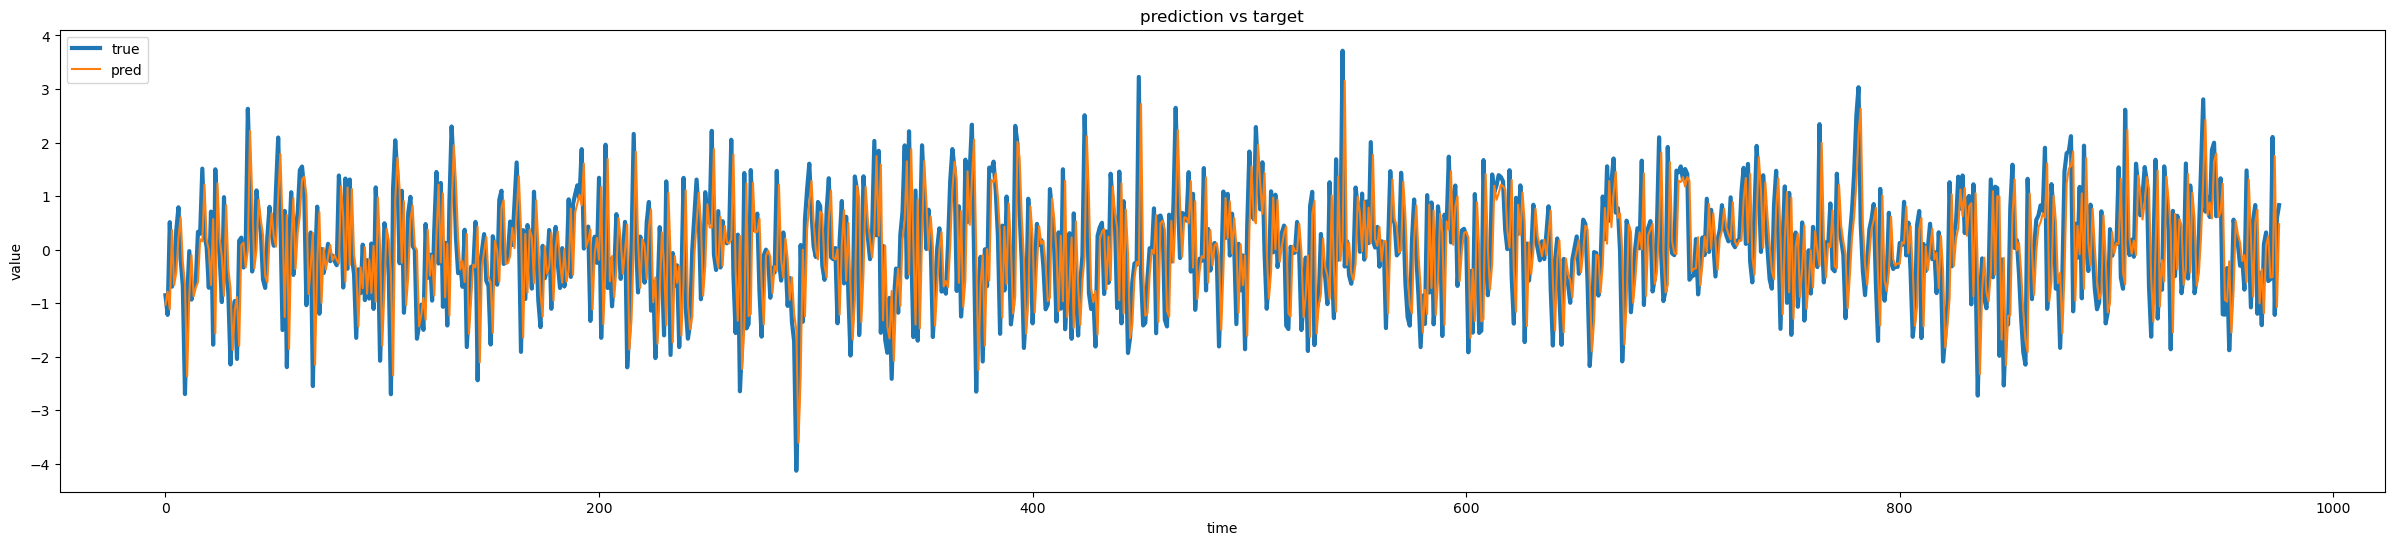

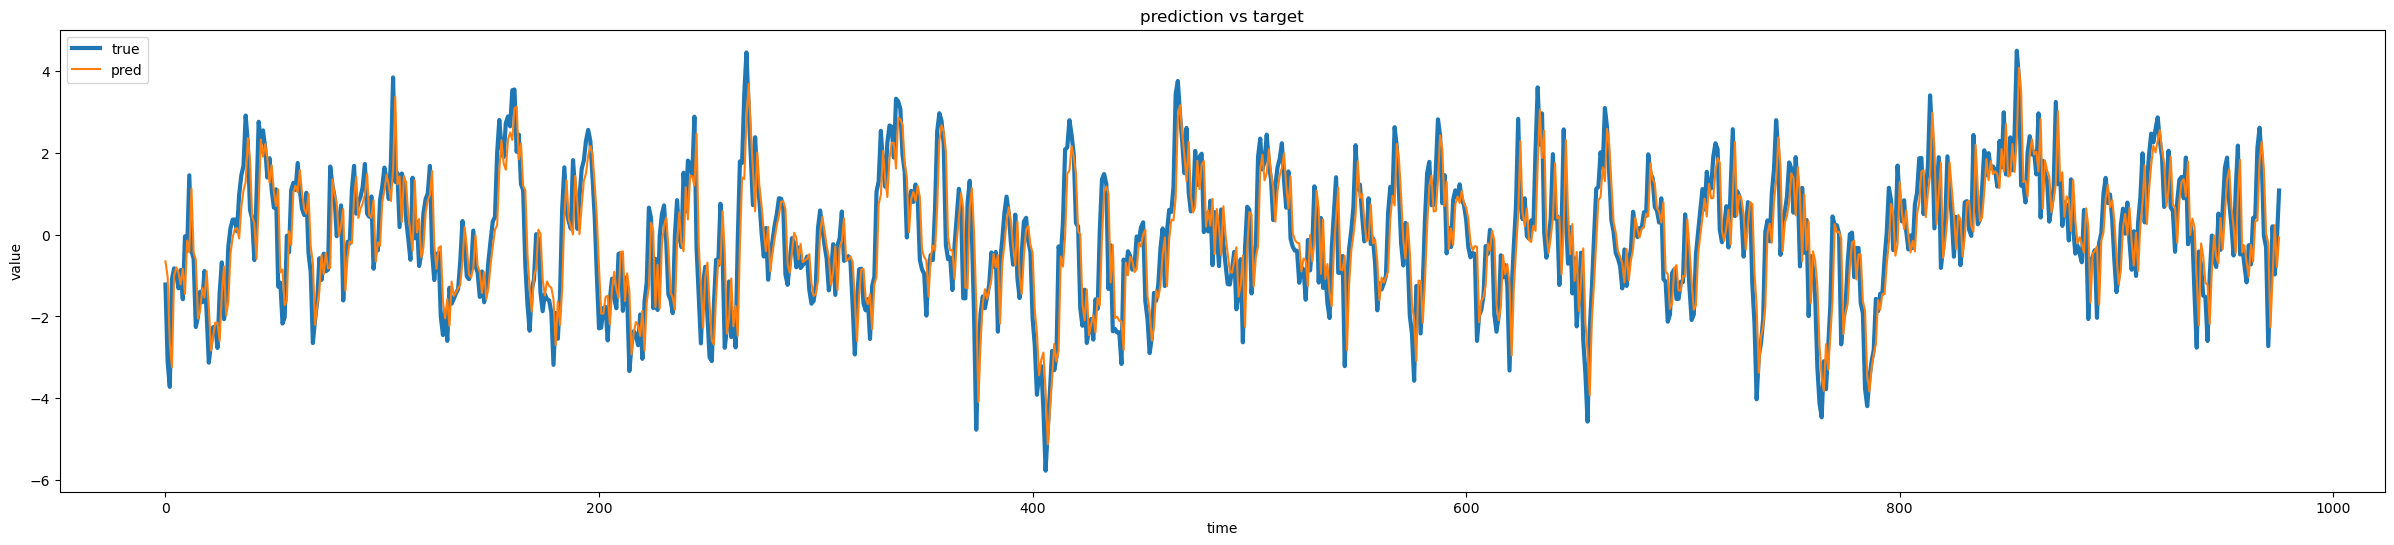

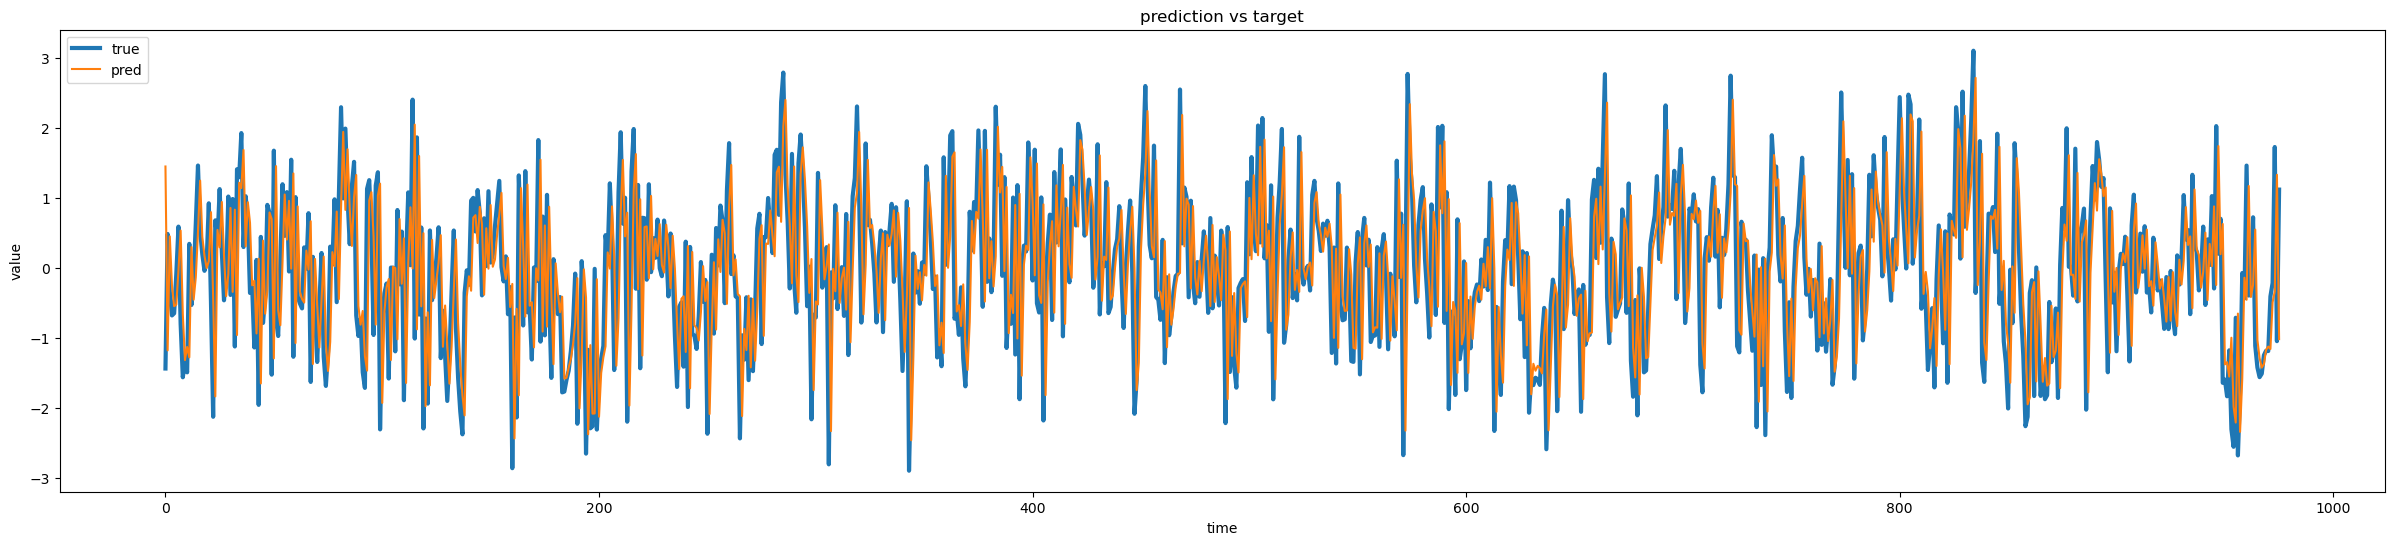

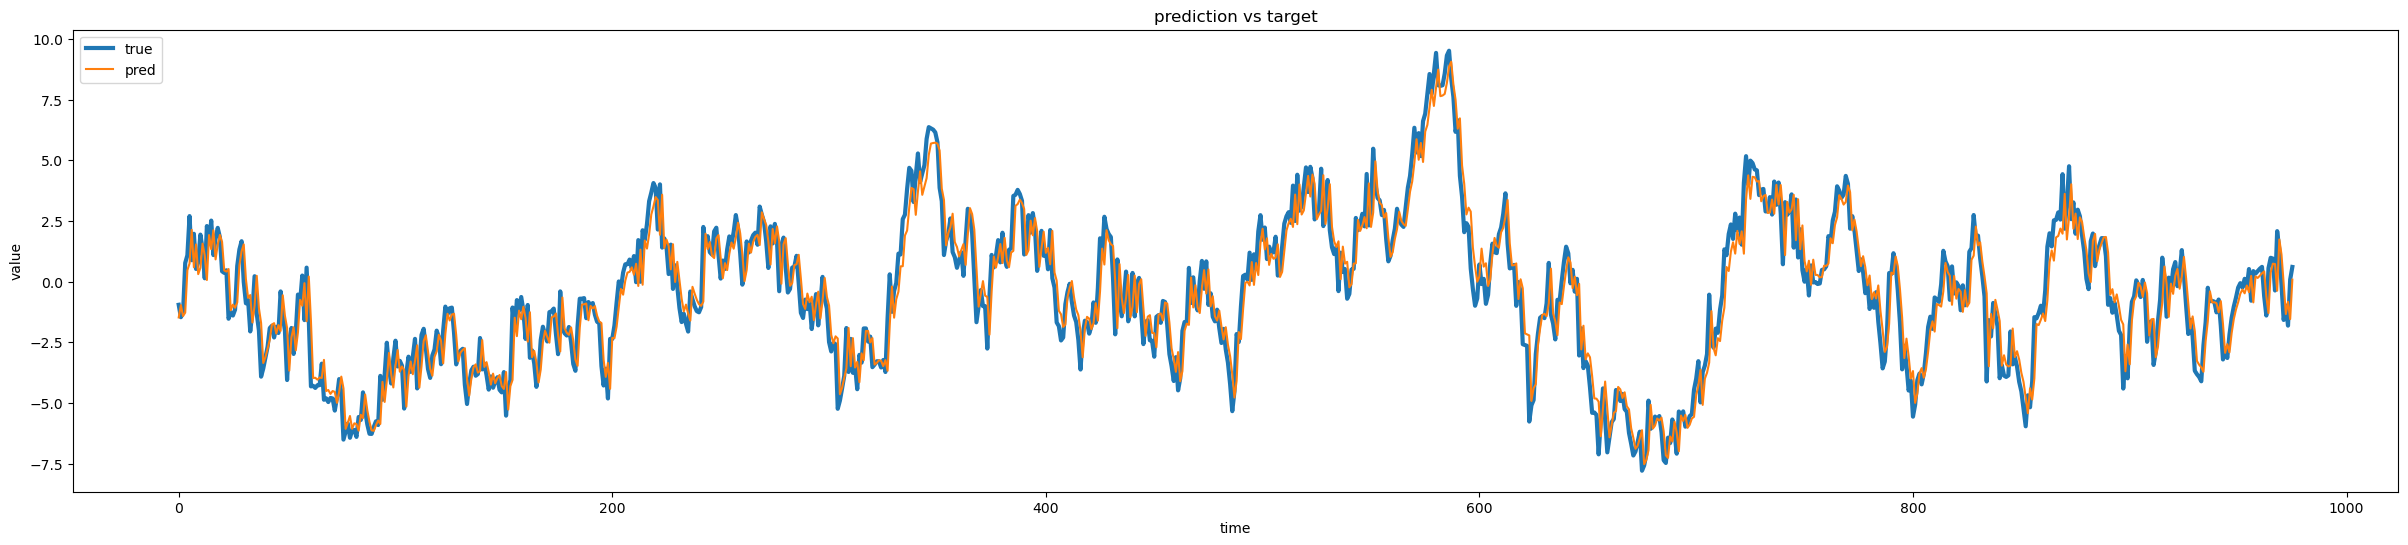

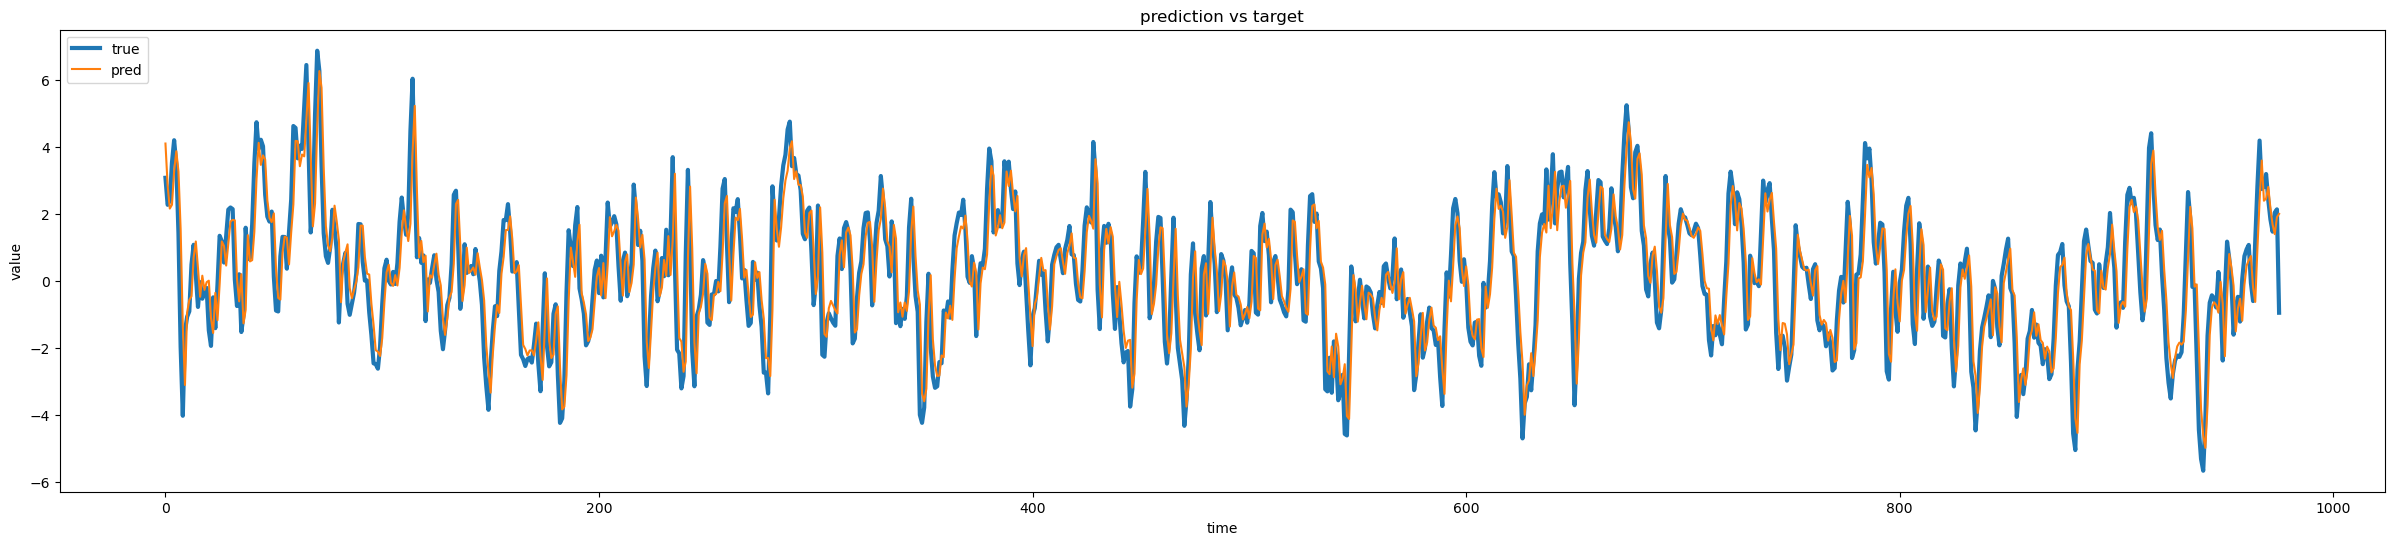

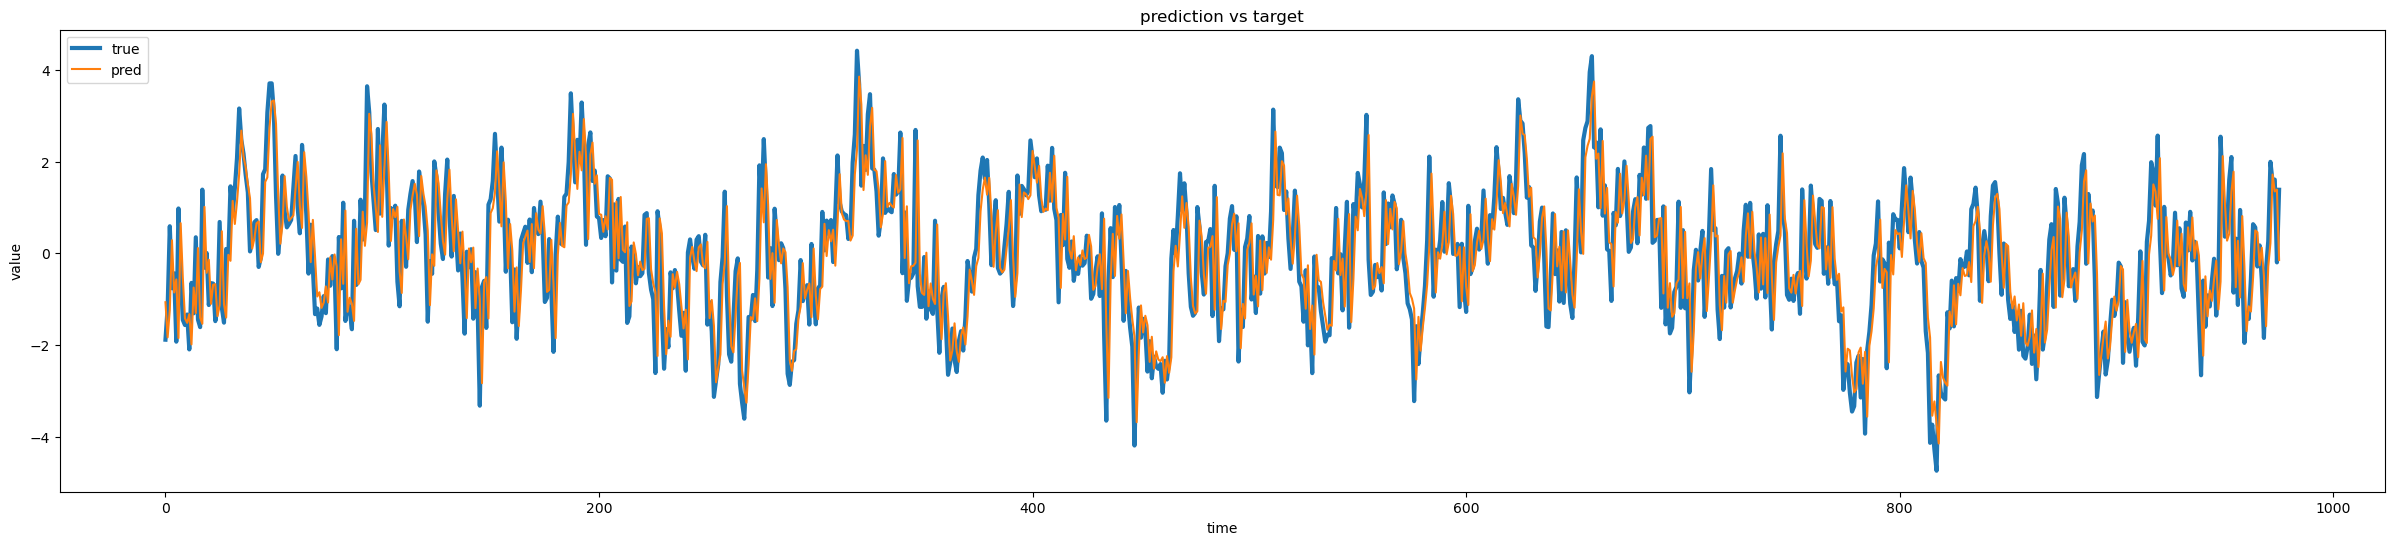

In [10]:
for i, preds in enumerate(predictions):
    plt.figure(figsize=(30, 6))
    plt.plot(test_dataS[i][24:], linewidth=3.0)
    plt.plot(preds)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.title('prediction vs target')
    plt.legend(('true', 'pred'), loc='upper left')

In [11]:
seed_everything(302)
test_dataS = []
test_dataS.append(generate_data('ar1', 1000, 0.2))
test_dataS.append(generate_data('ar1', 1000, 0.8))
test_dataS.append(generate_data('ar2', 1000, 0.2))
test_dataS.append(generate_data('ar2', 1000, 0.76))
test_dataS.append(generate_data('arma11', 1000, 0.7, 0.5))
test_dataS.append(generate_data('arma11', 1000, 0.9, -0.4))

test_loaderS = []
test_dataS_shifted = []
for test_data in test_dataS:
    
    shifted = np.add(test_data, 2)
    test_data = np.concatenate((test_data[:70], shifted[70:]))
    test_dataS_shifted.append(test_data)
    # Min-Max Scale
    test_data = test_data.flatten()
    test_scaled = list()
    for x in test_data:
        test_scaled.append((x-min_train)/(max_train-min_train))

    # Sliding Window
    test_size = len(test_scaled)
    test_x = list()
    for i in range(test_size-window_size):
        test_x.append(test_scaled[i:i+window_size])
    test_x = np.array(test_x).reshape(-1,window_size,1) # test Input
    test_y = np.array(test_scaled[window_size:]).reshape(-1,1,1)

    # Make it as an input to the model
    test_input = Variable(torch.Tensor(test_x)).to(device)
    test_loader = DataLoader(test_input, 1, shuffle=False)
    
    test_loaderS.append(test_loader)

In [12]:
predictions = []
for test_loader in test_loaderS:
    preds = opt.predict(test_loader)
    predictions.append(preds.flatten()*(max_train-min_train)+min_train)    

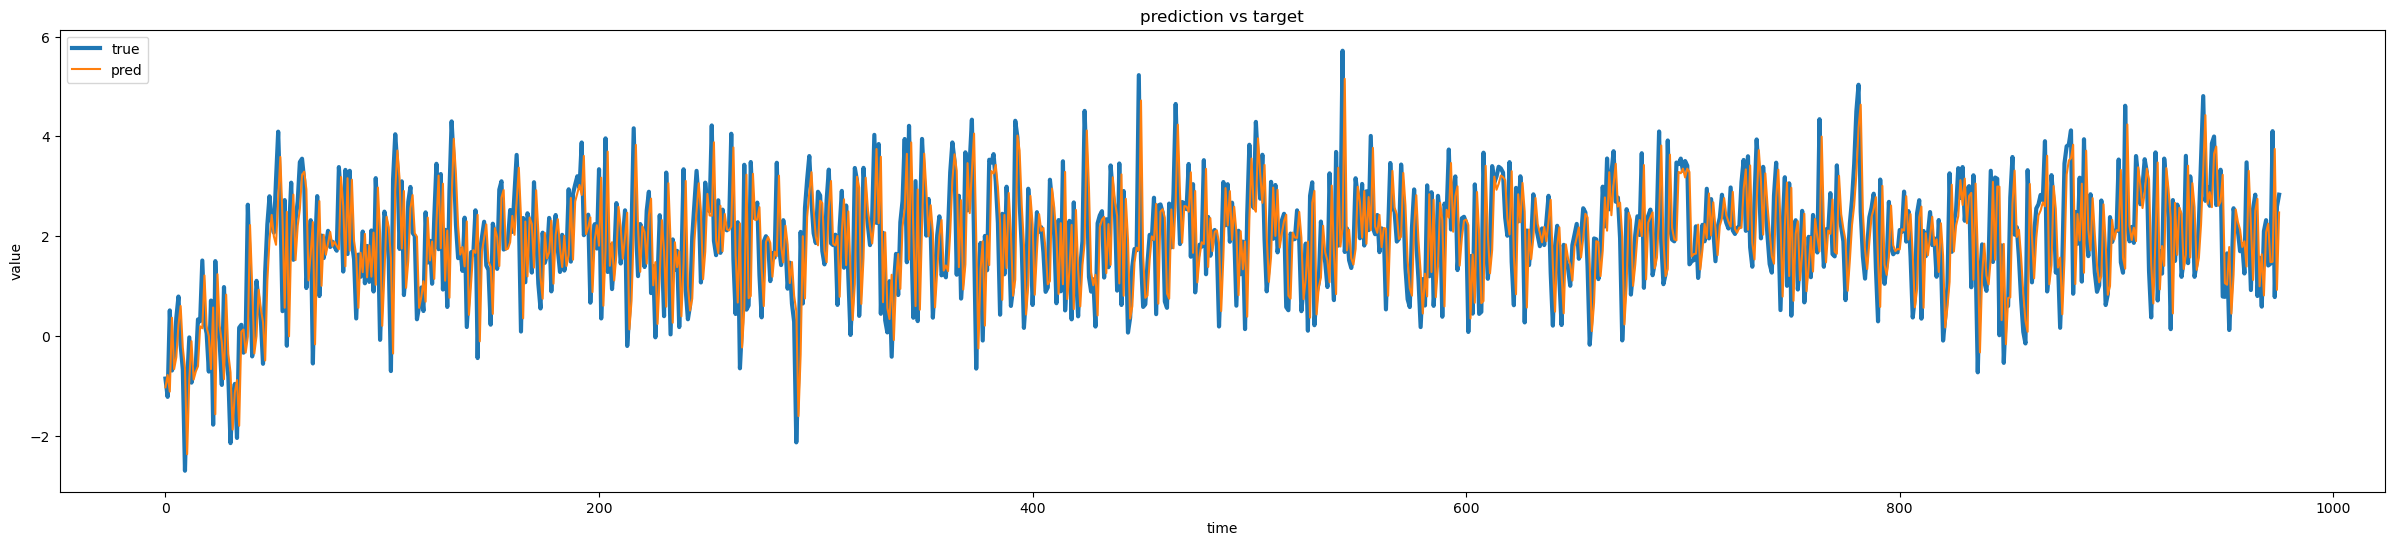

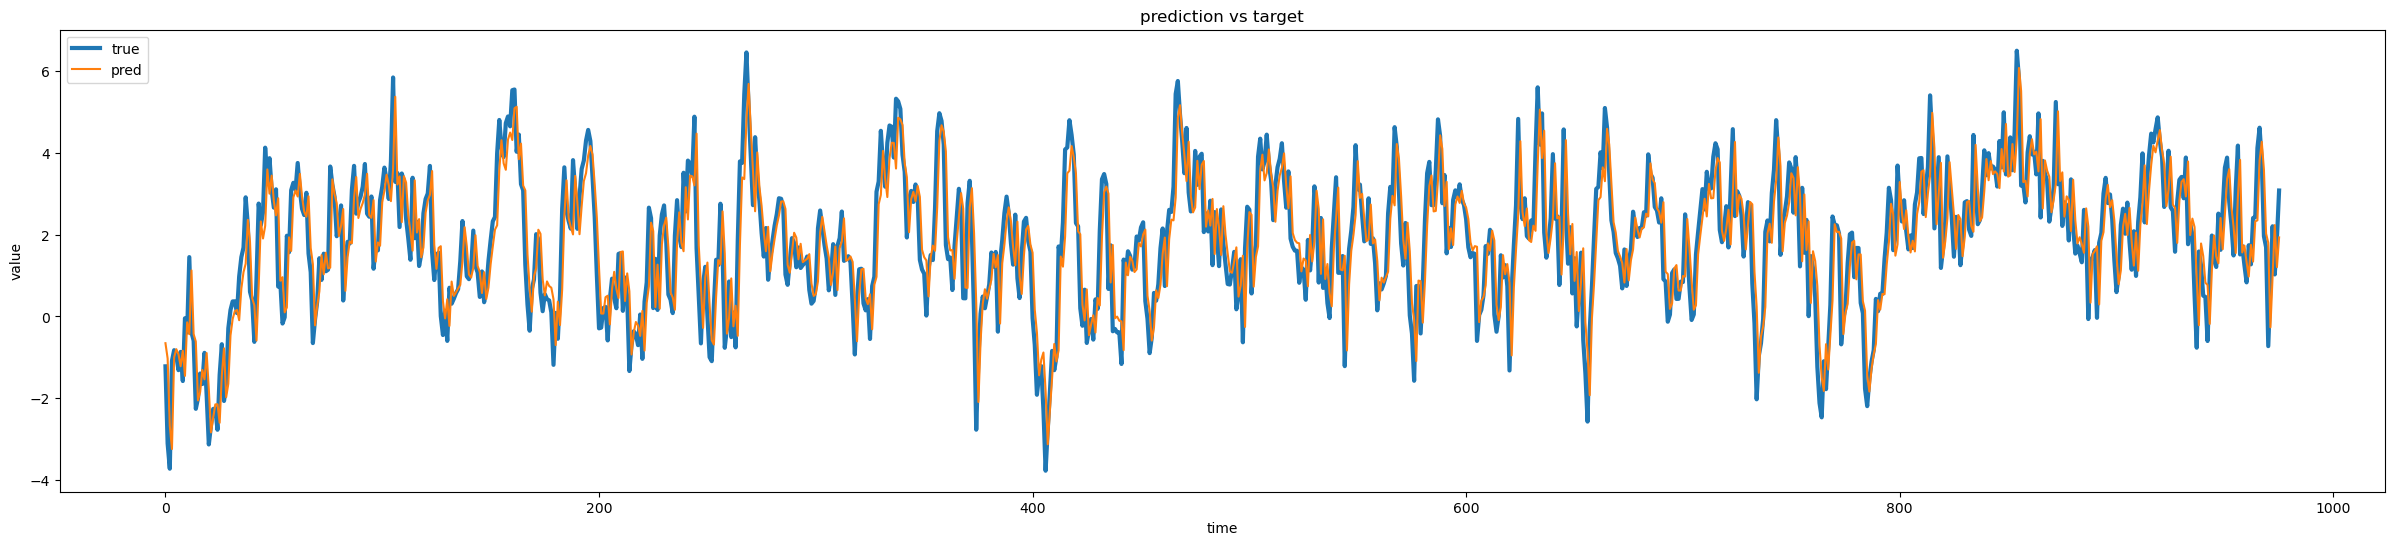

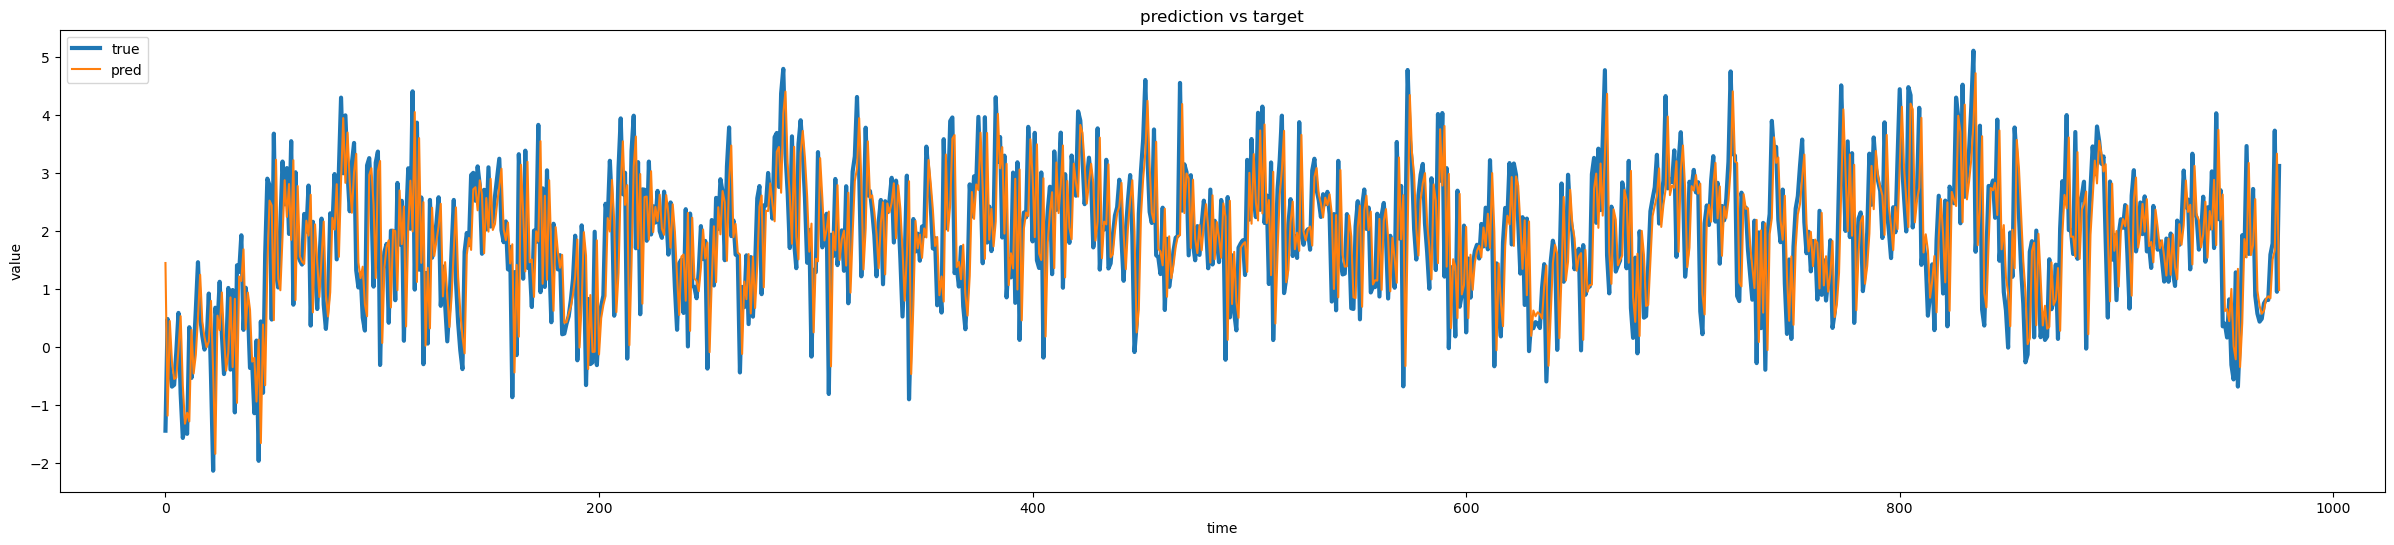

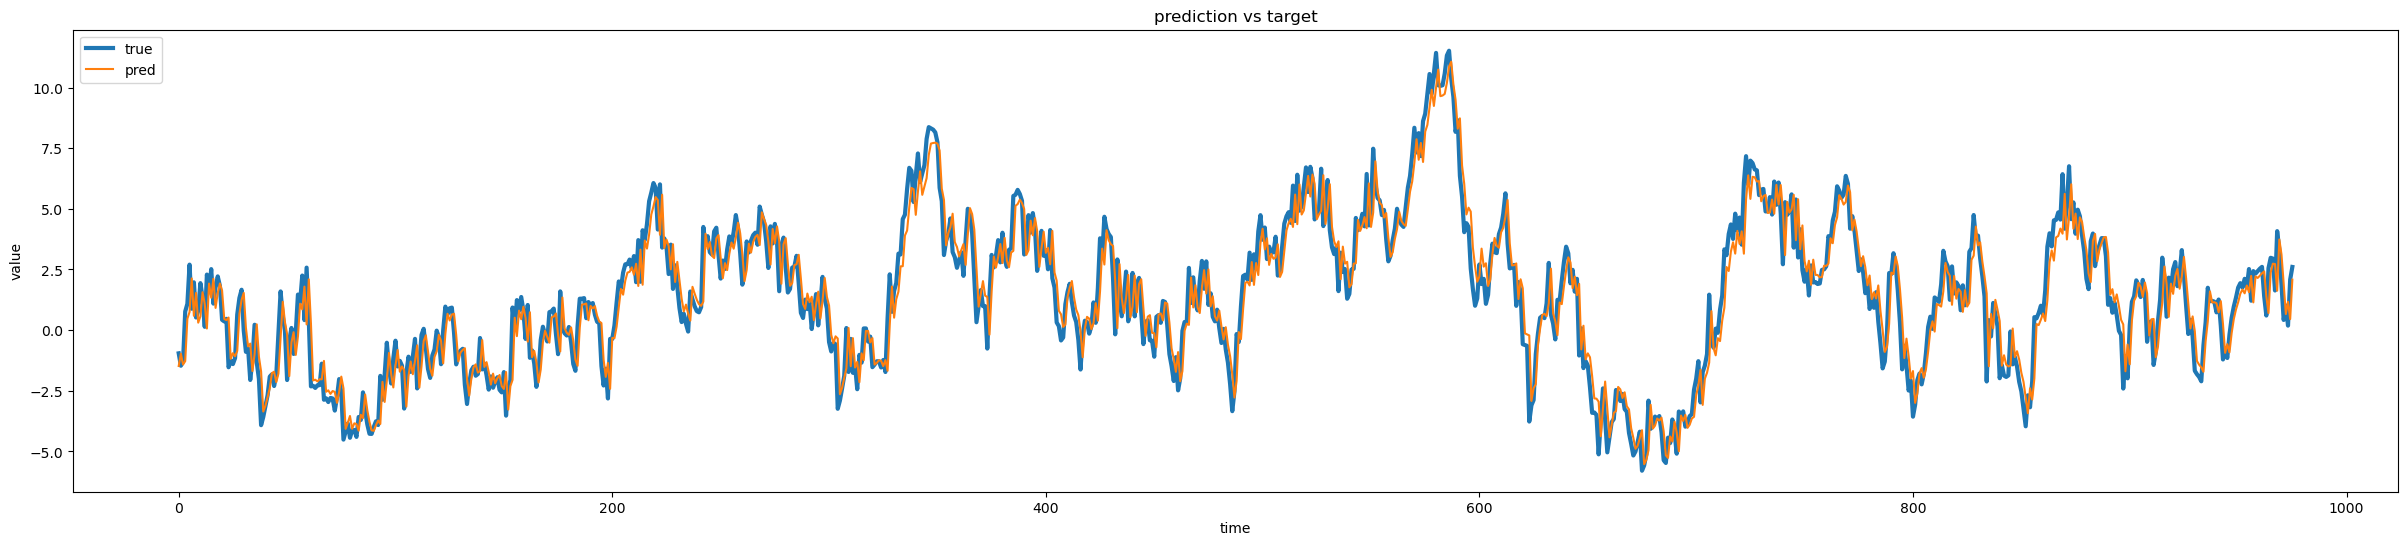

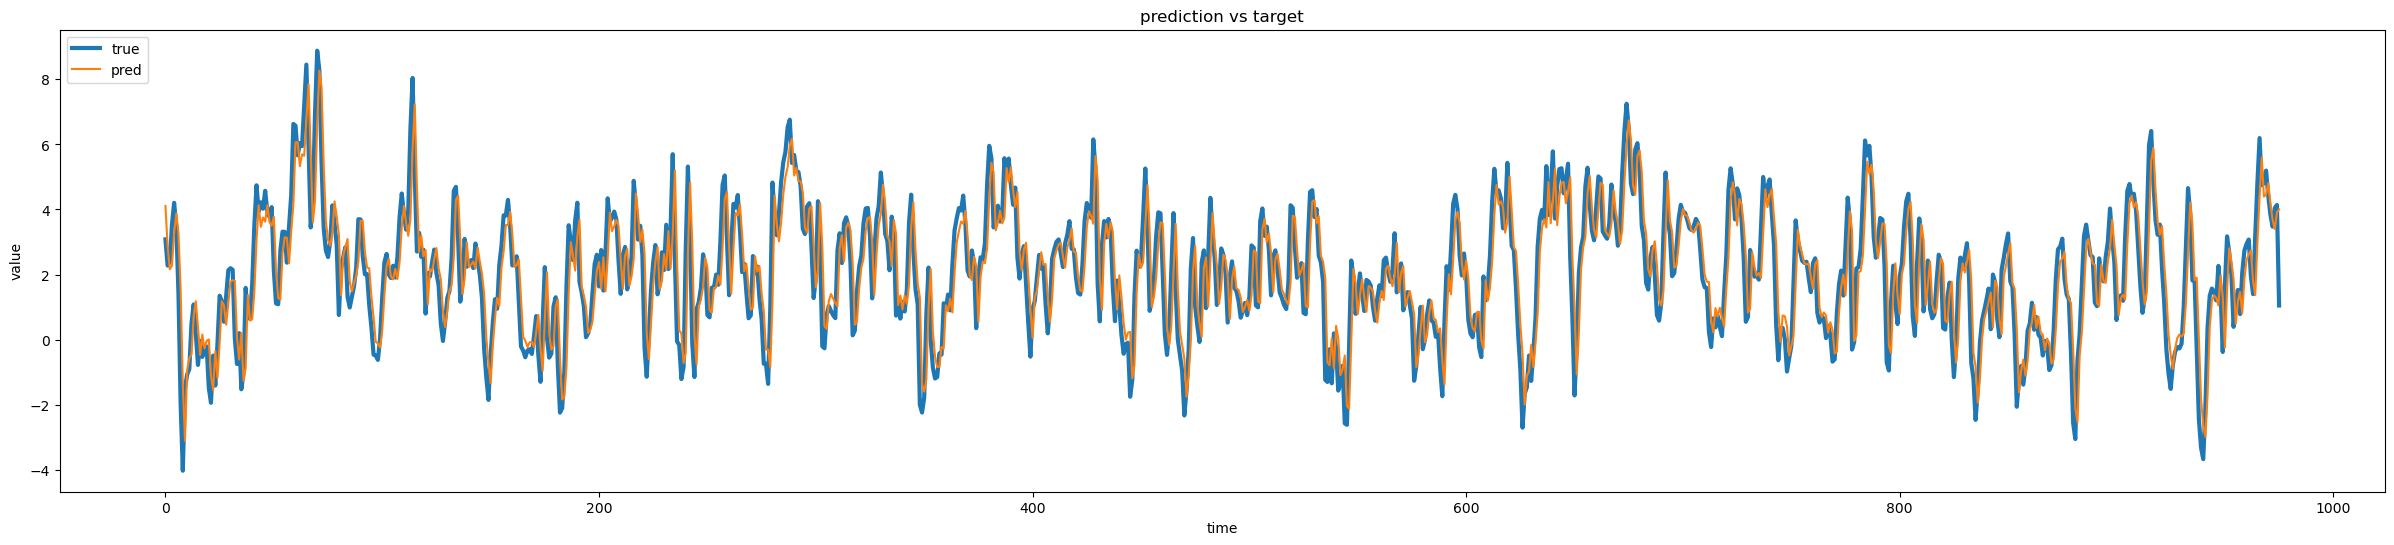

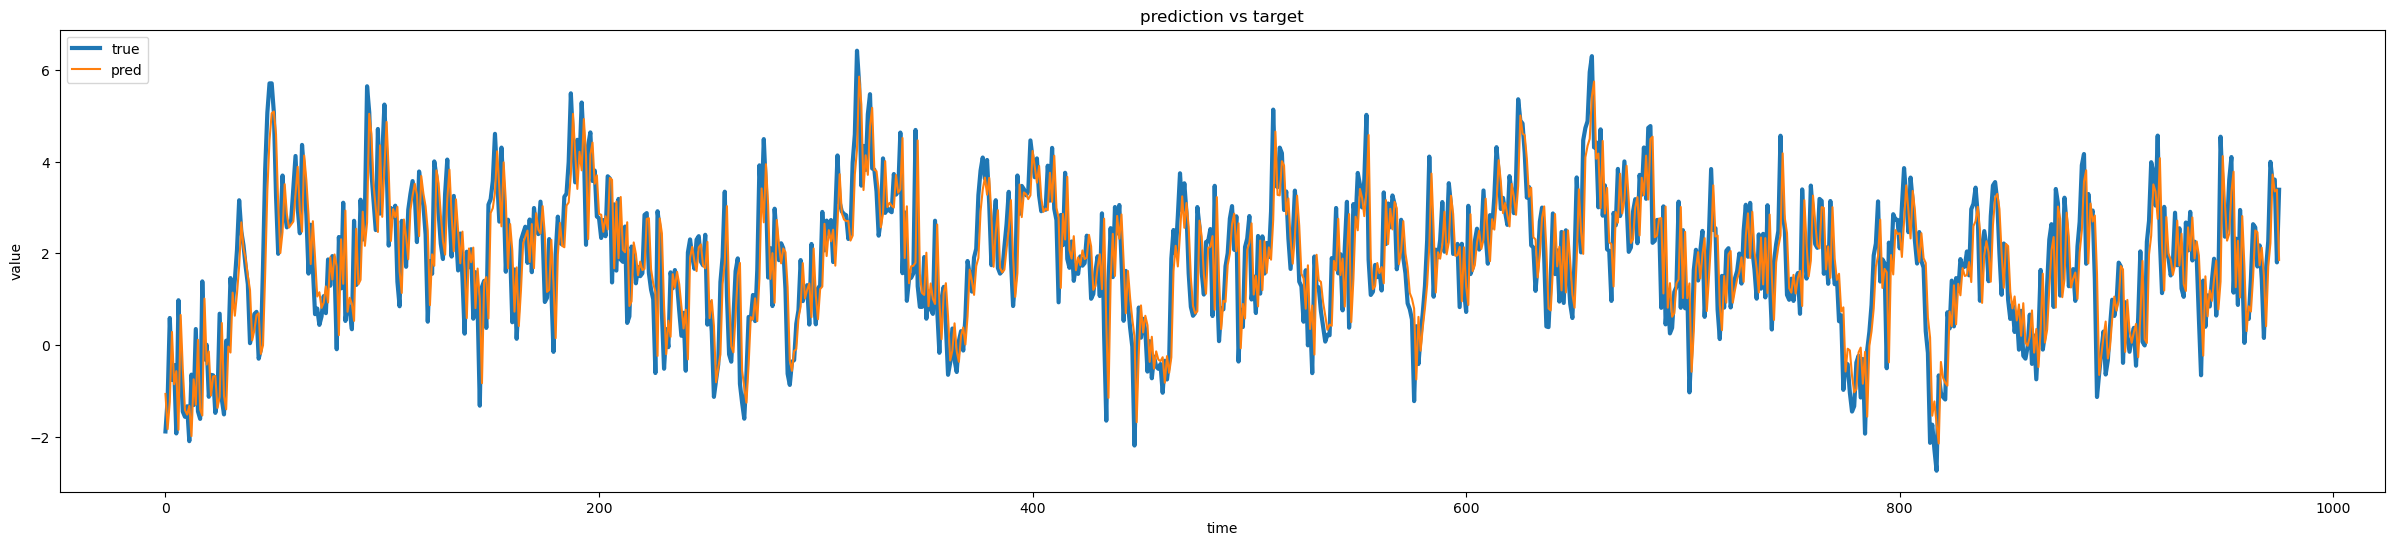

In [13]:
for i, preds in enumerate(predictions):
    plt.figure(figsize=(30, 6))
    plt.plot(test_dataS_shifted[i][24:], linewidth=3.0)
    plt.plot(preds)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.title('prediction vs target')
    plt.legend(('true', 'pred'), loc='upper left')